# Data loading and initial cleaning 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_excel('cookie_cats.xlsx')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [8]:
df.info() # here we found no missing value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [9]:
df.groupby('version').count() # here we count the size of each group

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


# Analysing player behaviour

<Axes: >

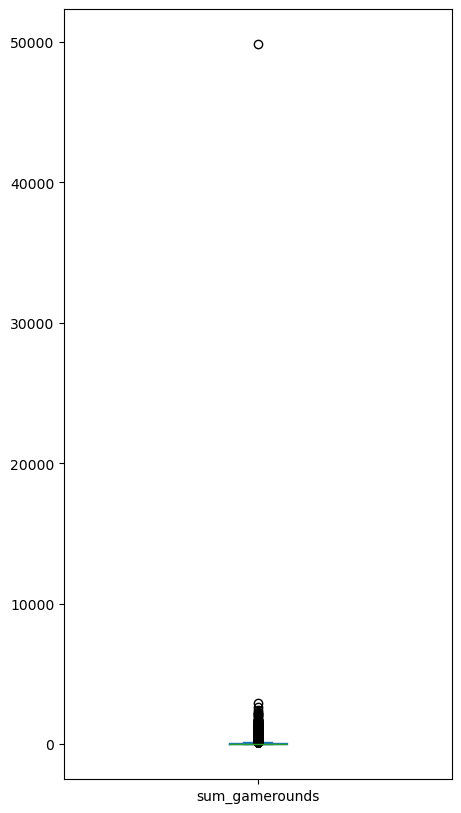

In [75]:
df['sum_gamerounds'].plot.box(figsize=(5,10))

In [11]:
df['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [12]:
plot_df = df.groupby('sum_gamerounds')['userid'].count() # group all users according to their game rounds and count each group
plot_df

sum_gamerounds
0        3994
1        5538
2        4606
3        3958
4        3629
         ... 
2294        1
2438        1
2640        1
2961        1
49854       1
Name: userid, Length: 942, dtype: int64

Text(0, 0.5, 'Number of players')

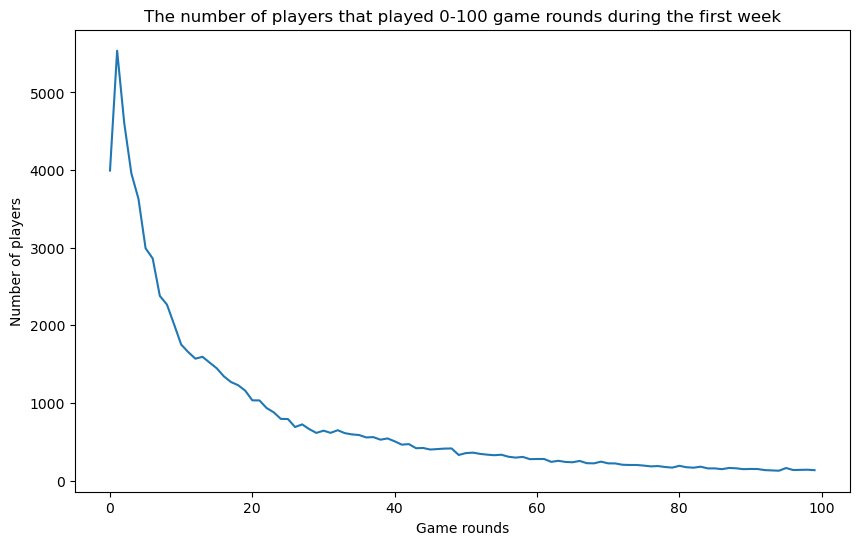

In [13]:
ax = plot_df[:100].plot(figsize = (10,6))
ax.set_title('The number of players that played 0-100 game rounds during the first week')
ax.set_xlabel('Game rounds')
ax.set_ylabel('Number of players')

# 1 day retention

## 1. bootstrapping

<Axes: ylabel='Density'>

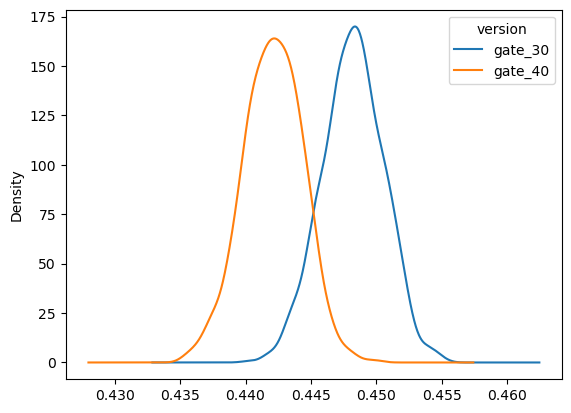

In [16]:
# frac=1: we want to include all rows (the whole part), replace = true means rows might be selected for multiple times

boot_1d = []
for i in range (1000):  # sampling will happen for 1000 times
    boot_mean = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_1d.append(boot_mean)
boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot(kind='density')

Probability that 1-day retention is greater when the gate is at level 30: 0.97


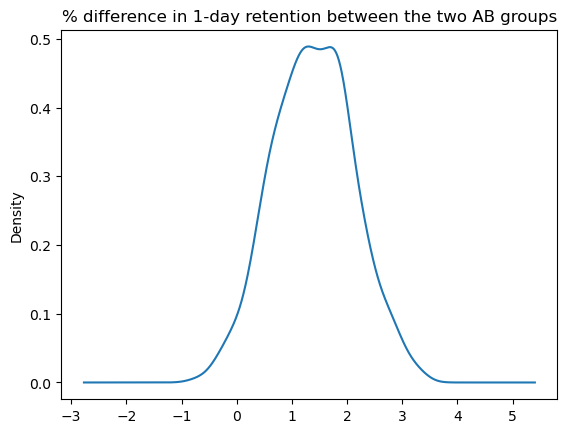

In [17]:
boot_1d['diff'] = (boot_1d.gate_30 - boot_1d.gate_40) / boot_1d.gate_40 * 100
ax = boot_1d['diff'].plot(kind='density')
ax.set_title('% difference in 1-day retention between the two AB groups')
print('Probability that 1-day retention is greater when the gate is at level 30:', (boot_1d['diff']>0).mean())

## 2. Mannual Z test

In [19]:
df[['version', 'userid','retention_1']].groupby('version').agg({'userid':'count', 'retention_1':'mean'})

,userid,retention_1
version,,
gate_30,44700,0.448188
gate_40,45489,0.442283


In [20]:
# Null hypothesis (H0): P1>=P0 (gate 40 perform at least as well as gate 30), alternative: P1<P0 (gate 40 performs worse than gate 30)
def z_test(p1, p0, n1, n0):
    delta = p1 - p0
    p = (p1*n1 + p0*n0) / (n1+n0)
    return delta/np.sqrt(p*(1-p)*(1/n1 + 1/n0))

z_value = z_test(0.442283, 0.448188, 45489, 44700)
z_value


-1.7840348624142948

In [21]:
from scipy.stats import norm
p_value = norm.cdf(z_value)  # here because our H1 is P1<P0, if on the other way we'll use 1 - norm.cdf(z_value)
p_value

0.037209000215798385

## 3. Z test using statsmodel

In [23]:
import statsmodels.api as sm
df[['version', 'userid','retention_1']].groupby('version').agg({'userid':'count','retention_1':'sum'})

,userid,retention_1
version,,
gate_30,44700,20034
gate_40,45489,20119


In [24]:
z_score, p_value = sm.stats.proportions_ztest([20119, 20034],[45489, 44700], alternative='smaller')
z_score, p_value

(-1.7840862247974725, 0.03720482764845957)

# 7-day retention

In [26]:
df.groupby('version')['retention_7'].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

## 1. Bootstrapping

Probability that 7-day retention is greater when the gate is at level 30: 1.0


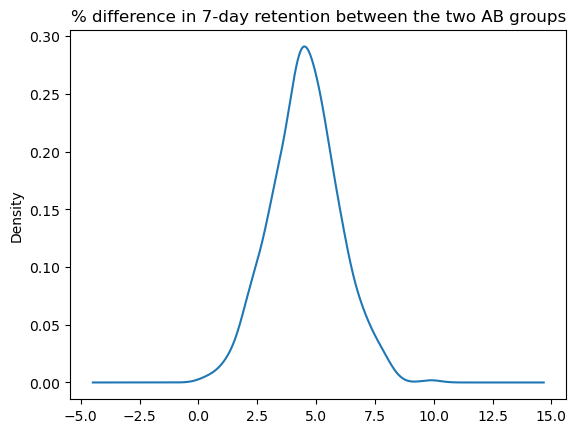

In [28]:
boot_7d = []
for i in range (500):
    boot_mean = df.sample(frac = 1, replace = True).groupby('version')['retention_7'].mean()
    boot_7d.append(boot_mean)
boot_7d = pd.DataFrame(boot_7d)
boot_7d['diff'] = (boot_7d.gate_30 - boot_7d.gate_40) / boot_7d.gate_40 * 100

ax = boot_7d['diff'].plot(kind='density')
ax.set_title('% difference in 7-day retention between the two AB groups')
print('Probability that 7-day retention is greater when the gate is at level 30:', (boot_7d['diff'] > 0).mean())

## 2. Manual z test

In [30]:
# Null hypothesis (H0): P1>=P0 (gate 40 perform at least as well as gate 30), alternative: P1<P0 (gate 40 performs worse than gate 30)
df[['version', 'userid','retention_7']].groupby('version').agg({'userid':'count', 'retention_7':'mean'})

,userid,retention_7
version,,
gate_30,44700,0.190201
gate_40,45489,0.182000


In [31]:
z_value = z_test(0.182000, 0.190201, 45489, 44700)
z_value

-3.1642450700987754

In [32]:
from scipy.stats import norm
p_value = norm.cdf(z_value)
p_value

0.0007774290494431602

## 3. Z test in statsmodel

In [34]:
import statsmodels.api as sm
df[['version', 'userid','retention_7']].groupby('version').agg({'userid':'count','retention_7':'sum'})

,userid,retention_7
version,,
gate_30,44700,8502
gate_40,45489,8279


In [35]:
z_score, p_value = sm.stats.proportions_ztest([8279, 8502],[45489, 44700], alternative='smaller')
z_score, p_value

(-3.164358912748191, 0.0007771249878071645)

# Conclusion

## For 1 day retention:
## The probability of retentsion is greater when gate is at 30 is 97% comparied to when gate is at 40; through statistical test (2 sample z test), p (0.037)<0.05, we can reject the null hypothesis and accept the alternative, which is gate 30 is doing better than gate 40. Over all, gate 30 performs better than gate 40 in 1 day user retention.

## For 7 day retention:
## The probability of retentsion is greater when gate is at 30 is 100% comparied to when gate is at 40; through statistical test (2 sample z test), p (0.0007)<0.05, we can reject the null hypothesis and accept the alternative, which is gate 30 is doing better than gate 40. Overall, gate 30 performs better than gate 40 in 7 days user retention.

# EDA: correlation between user retention rate and game rounds (in first 30 rounds)

In [56]:
# we filter out the user over 30 rounds / 100 rounds
df['is_outlier_30'] = df['sum_gamerounds'].apply(lambda x: 1 if x > 30 else 0)
df_30 = df[-df['is_outlier_30'].astype(bool)]
df_100 = df[-df['is_outlier_100'].astype(bool)]

In [58]:
cohort_groups_30 = df_30.groupby(['version', 'sum_gamerounds'])
cohort_data_30 = cohort_groups_30.agg(
    user_count = ('userid', 'count'),
    retention_1_rate = ('retention_1', lambda x: x.sum() / x.count()),  # can also use x.mean()
    retention_7_rate = ('retention_7', lambda x: x.sum() / x.count())
).reset_index()  # need to reset_index(), otherwise the version and sum_gamerounds will become part of the index
cohort_data_30

,version,sum_gamerounds,user_count,retention_1_rate,retention_7_rate
0,gate_30,0,1937,0.021167,0.008260
1,gate_30,1,2749,0.031648,0.007275
2,gate_30,2,2198,0.059145,0.012284
3,gate_30,3,1899,0.073723,0.010532
4,gate_30,4,1831,0.099945,0.020208
...,...,...,...,...,...
57,gate_40,26,337,0.578635,0.094955
58,gate_40,27,370,0.575676,0.094595
59,gate_40,28,310,0.612903,0.112903
60,gate_40,29,311,0.655949,0.118971


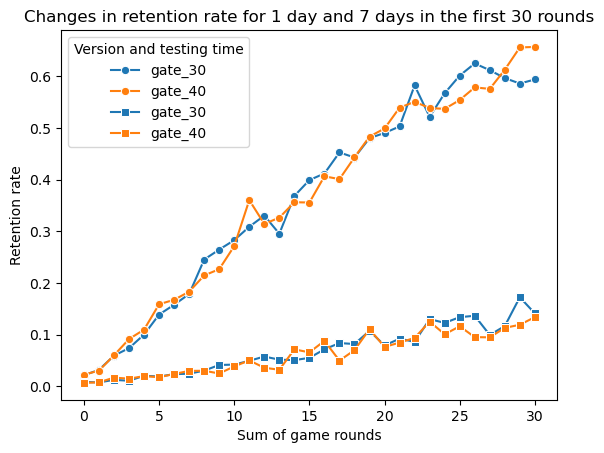

In [81]:
import seaborn as sns
# for the first 30 rounds
sns.lineplot(data = cohort_data_30, x='sum_gamerounds', y='retention_1_rate', hue='version', marker = 'o')
sns.lineplot(data = cohort_data_30, x='sum_gamerounds', y='retention_7_rate', hue='version', marker = 's')

plt.title('Changes in retention rate for 1 day and 7 days in the first 30 rounds')
plt.xlabel('Sum of game rounds')
plt.ylabel('Retention rate')
plt.legend(title='Version and testing time')

# EDA: correlation between suer retention rate and game rounds (in first 100 rounds)

In [62]:
df['is_outlier_100'] = df['sum_gamerounds'].apply(lambda x: 1 if x > 100 else 0)
df_100 = df[-df['is_outlier_100'].astype(bool)]

cohort_groups_100 = df_100.groupby(['version', 'sum_gamerounds'])
cohort_data_100 = cohort_groups_100.agg(
    user_count = ('userid', 'count'),
    retention_1_rate = ('retention_1', lambda x: x.sum() / x.count()),
    retention_7_rate = ('retention_7', lambda x: x.sum() / x.count())
).reset_index()  # need to reset_index(), otherwise the version and sum_gamerounds will become part of the index
cohort_data_100

,version,sum_gamerounds,user_count,retention_1_rate,retention_7_rate
0,gate_30,0,1937,0.021167,0.008260
1,gate_30,1,2749,0.031648,0.007275
2,gate_30,2,2198,0.059145,0.012284
3,gate_30,3,1899,0.073723,0.010532
4,gate_30,4,1831,0.099945,0.020208
...,...,...,...,...,...
197,gate_40,96,70,0.814286,0.285714
198,gate_40,97,80,0.862500,0.350000
199,gate_40,98,72,0.805556,0.375000
200,gate_40,99,66,0.833333,0.393939


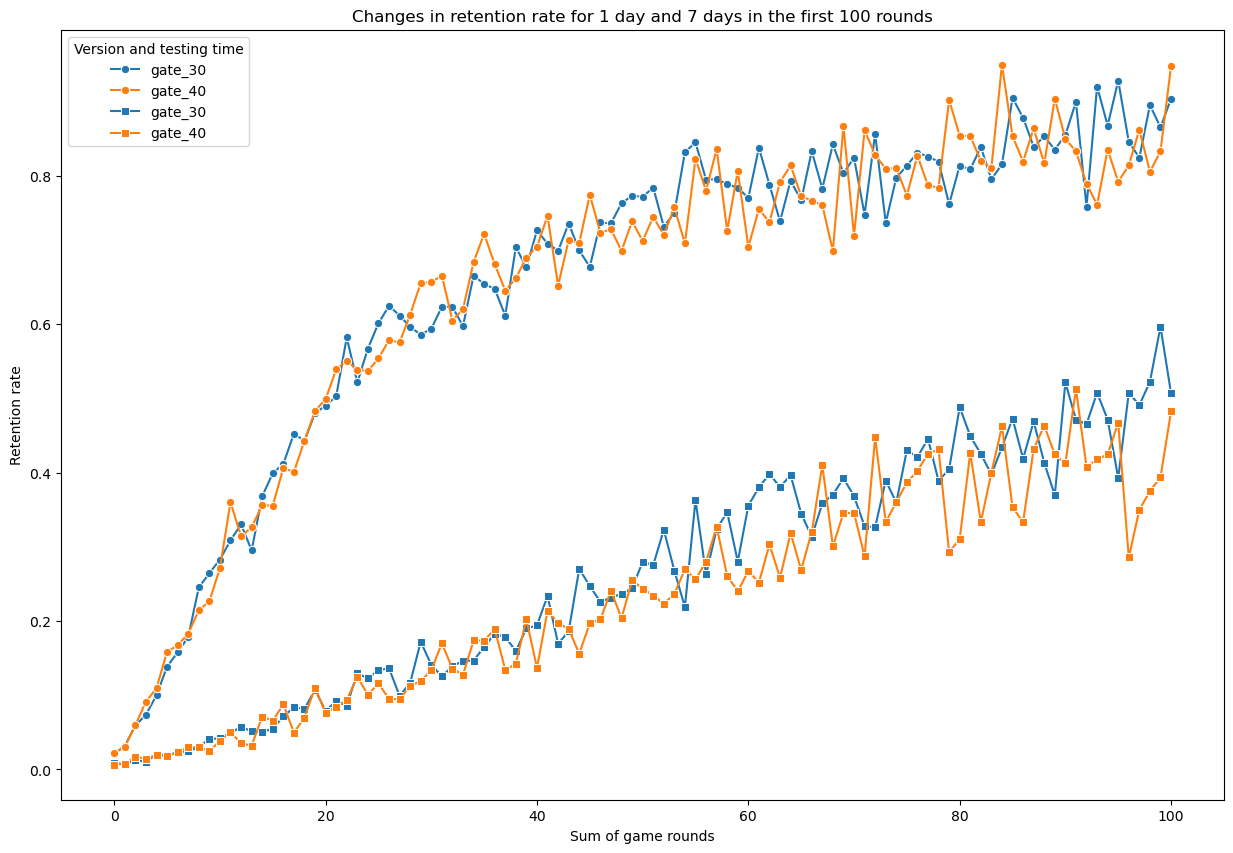

In [73]:
plt.figure(figsize=(15,10))
sns.lineplot(data = cohort_data_100, x='sum_gamerounds', y='retention_1_rate', hue='version', marker = 'o')
sns.lineplot(data = cohort_data_100, x='sum_gamerounds', y='retention_7_rate', hue='version', marker = 's')

plt.title('Changes in retention rate for 1 day and 7 days in the first 100 rounds')
plt.xlabel('Sum of game rounds')
plt.ylabel('Retention rate')
plt.legend(title='Version and testing time')

In [85]:
df[['retention_1','retention_7','sum_gamerounds']].corr()

,retention_1,retention_7,sum_gamerounds
retention_1,1.000000,0.327401,0.197603
retention_7,0.327401,1.000000,0.279288
sum_gamerounds,0.197603,0.279288,1.000000


<Axes: >

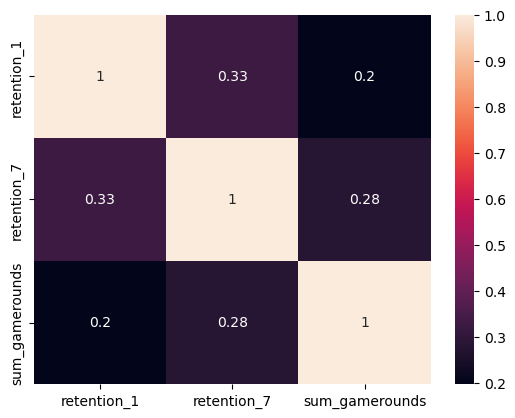

In [87]:
sns.heatmap(df[['retention_1','retention_7','sum_gamerounds']].corr(), annot=True)